# Sensorbasierte Aktivitätserkennung – Preprocessing Pipeline

Dieses Notebook beschreibt den vollständigen Preprocessing-Workflow für die sensorbasierten Aktivitätsdaten.
Ziel ist es, sowohl klassische ML-Features (NDL) als auch Deep Learning Sequenzen (DL) vorzubereiten.

---
## Inhaltsverzeichnis

1. Rohdaten laden und vorbereiten
2. Zeitbasiertes Trimmen & Resampling
3. Segmentierung in überlappende Zeitfenster
4. Filterung & Glättung jedes Segments
5. Feature-Extraktion (für NDL)
6. Label-Zuordnung
7. Sequenzbildung (für DL)


---

## 1. Projekt-Setup

### Importe und Projektverzeichnis

In dieser Zelle werden zentrale Python-Module importiert, darunter pandas, numpy, matplotlib, pathlib und shutil. Zusätzlich wird der Projekt-Stammordner bestimmt, indem von der aktuellen Datei (__file__) der Elternordner genommen wird. Dies dient dazu, alle relativen Pfade konsistent vom Projektstamm aus zu organisieren.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import shutil
import sys
import scipy.signal as signal

# Projektverzeichnis 
project_root = Path().resolve().parent

### Roh-ZIPs entpacken & Parquet-Dateien erzeugen  

Viele Sensor-Sessions liegen noch als ZIP-Archive mit Roh-CSV-Dateien vor.  
Die Funktion **process_all_zips()** entpackt jede ZIP-Datei, lädt die enthaltene(n) CSV, führt minimale Typ-Bereinigung durch und schreibt eine Parquet-Datei pro Session nach  
`data/processed/per_file/…`.  
Damit steht der gleiche Datenbestand zur Verfügung, den die Command-Line-Pipeline nutzt.

In [3]:
import zipfile
from pathlib import Path
import pandas as pd

RAW_ZIP_DIR   = project_root / "data" / "raw"
PER_FILE_DIR  = project_root / "data" / "processed" / "per_file"
PER_FILE_DIR.mkdir(parents=True, exist_ok=True)

def process_all_zips(
    zip_dir: Path = RAW_ZIP_DIR,
    out_dir: Path = PER_FILE_DIR,
    pattern: str = "*.zip"
) -> None:
    """
    ▸ Iteriert über alle ZIP-Archive in *zip_dir*  
    ▸ Entpackt sie in einen temporären Ordner  
    ▸ Konvertiert jede enthaltene CSV zu einer Parquet-Datei  
      (Dateiname = ZIP-Name + laufende Nummer)  

    Hinweise
    --------
    * Verwendet `zipfile.ZipFile.extractall`, siehe Python-Std-Lib  [oai_citation:0‡docs.python.org](https://docs.python.org/3/library/zipfile.html?utm_source=chatgpt.com)  
    * Schreibt mit `DataFrame.to_parquet`, siehe pandas-Doc  [oai_citation:1‡pandas.pydata.org](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_parquet.html?utm_source=chatgpt.com)
    """
    tmp_root = out_dir / "__tmp_extract"
    tmp_root.mkdir(parents=True, exist_ok=True)

    for zip_path in zip_dir.glob(pattern):
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(tmp_root)

        csv_files = list(tmp_root.rglob("*.csv"))
        if not csv_files:
            print(f"⚠️  {zip_path.name}: keine CSV gefunden")
            continue

        for idx, csv in enumerate(csv_files):
            try:
                df = pd.read_csv(csv)
            except Exception as e:
                print(f"❌ {csv.name}: {e}")
                continue

            session_name = f"{zip_path.stem}_{idx:02d}.parquet"
            out_file = out_dir / session_name
            df.to_parquet(out_file, index=False)
            print(f"✔️ geschrieben → {out_file.relative_to(project_root)}")

        # Temp-Ordner leeren
        for f in tmp_root.iterdir():
            if f.is_file():
                f.unlink()
            else:
                shutil.rmtree(f)

### Pfad zur Datenquelle definieren

Hier wird der Pfad zu den vorverarbeiteten Parquet-Dateien pro Session gesetzt: data/processed/per_file. Anschließend wird eine Liste aller .parquet-Dateien erstellt. Diese Dateien stellen die Rohdaten pro Session dar. Ein Fehler wird geworfen, wenn keine Dateien vorhanden sind.

In [4]:
# Verzeichnis mit per-file-Parquet-Dateien
PER_FILE_DIR = project_root / "data" / "processed" / "per_file"

# Parquet-Dateien auflisten
all_parquets = list(PER_FILE_DIR.glob("*.parquet"))
if len(all_parquets) == 0:
    raise FileNotFoundError(f"Keine .parquet-Dateien im Ordner {PER_FILE_DIR} gefunden.")

### Zufällige Auswahl einer Datei
Mit einem gesetzten Seed (420) wird eine Datei zufällig aus den geladenen Parquet-Dateien ausgewählt. Diese Datei wird in ein DataFrame namens **df_raw_full** geladen und die ersten drei Zeilen werden zur Kontrolle ausgegeben. Dies dient als Startpunkt für den weiteren Preprocessing-Workflow.

In [5]:
np.random.seed(420)
random_file = np.random.choice(all_parquets)
print(f"▶ Verwende zufällig ausgewählte Datei: {random_file.name}")

# Laden & Anzeigen der Rohdaten
df_raw_full = pd.read_parquet(random_file)
print("\n--- Erste 3 Zeilen roher Session-Daten ---")
display(df_raw_full.head(3))

▶ Verwende zufällig ausgewählte Datei: sitting_6-2025_04_13_13-10-42.parquet

--- Erste 3 Zeilen roher Session-Daten ---


,seconds_elapsed,accelerometer_x,accelerometer_y,accelerometer_z,magnetometer_x,magnetometer_y,magnetometer_z,gravity_x,gravity_y,gravity_z,...,orientation_qw,orientation_qx,orientation_qy,orientation_qz,time,activity,device_id,device_name,app_version,file_hash
0,0.021627,0.148945,-0.417483,1.021942,27.298569,-43.312744,-16.961914,-0.517652,-7.666539,-6.093161,...,-0.892808,-0.434283,-0.027077,-0.116440,2025-05-02 13:10:42.940627500,sitting,0e7f697a-d191-469a-868d-042cd16e8d3c,iPhone 15,1.43.2,None
1,0.031609,0.027196,-0.566070,0.594735,27.506668,-43.307220,-16.921646,-0.491970,-7.664298,-6.098106,...,-0.893213,-0.433966,-0.027501,-0.114405,2025-05-02 13:10:42.950609200,sitting,0e7f697a-d191-469a-868d-042cd16e8d3c,iPhone 15,1.43.2,None
2,0.041591,-0.022383,-0.638774,0.233324,27.644333,-43.218445,-17.054001,-0.453763,-7.660725,-6.105552,...,-0.893677,-0.433455,-0.028639,-0.112420,2025-05-02 13:10:42.960591400,sitting,0e7f697a-d191-469a-868d-042cd16e8d3c,iPhone 15,1.43.2,None


### Plot-Funktion definieren
Hier wird eine Funktion plot_data(...) definiert, um x, y und z-Daten eines DataFrames über der Zeit zu plotten. Optional kann ein Vergleich mit einem weiteren DataFrame erfolgen (z. B. resamplete Daten). Zusätzlich können Dauerfilter, benutzerdefinierte Kommentare und Transparenzwerte angegeben werden. Diese Funktion wird mehrfach im Notebook genutzt, um Vorher-Nachher-Vergleiche zu visualisieren.

In [6]:
def plot_data(df: pd.DataFrame, title: str, duration: float = None, compare_to: pd.DataFrame = None, own_comment: str = None, alpha: float = 0.7, axes_name: str = None ,axes_name_compare: str = None):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df muss einen DatetimeIndex haben.")
    if compare_to is not None and not isinstance(compare_to.index, pd.DatetimeIndex):
        raise ValueError("compare_to muss einen DatetimeIndex haben.")

    data = df.copy()
    if duration is not None:
        if duration > 0:
            t0 = data.index.min()
            t_end = t0 + pd.Timedelta(seconds=duration)
        else:
            t_end = data.index.max()
            t0 = t_end + pd.Timedelta(seconds=duration)  # duration ist negativ
        data = data[(data.index >= t0) & (data.index <= t_end)]
        if compare_to is not None:
            compare_to = compare_to[(compare_to.index >= t0) & (compare_to.index <= t_end)]

    if axes_name is not None:
        axes_named = axes_name
    else:
        axes_named = ""

    if compare_to is not None:
        if axes_name_compare is not None:
            axes_name_compared = axes_name_compare
        else:
            axes_name_compared = " resampled"
    

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data.index, data['x'], label='x' + axes_named, color='red', alpha=alpha)
    ax.plot(data.index, data['y'], label='y' + axes_named, color='green', alpha=alpha)
    ax.plot(data.index, data['z'], label='z' + axes_named, color='blue', alpha=alpha)

    if compare_to is not None:
        ax.plot(compare_to.index, compare_to['x'], label='x' + axes_name_compared, color='red', linestyle='--')
        ax.plot(compare_to.index, compare_to['y'], label='y' + axes_name_compared, color='green', linestyle='--')
        ax.plot(compare_to.index, compare_to['z'], label='z' + axes_name_compared, color='blue', linestyle='--')

    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Acceleration")
    ax.legend()
    ax.grid(True)
    default_comment = (
        "Die Variablen wurden für den Plot wie folgt umbenannt:\n"
        "accelerometer_x → x, accelerometer_y → y, accelerometer_z → z"
    )
    if own_comment:
        comment = own_comment + "\n" + "\n" + default_comment
    else:
        comment = default_comment
    fig.text(0.5, -0.08, comment, ha='center', fontsize=9, style='italic')

    plt.tight_layout()
    plt.show()


### Vorverarbeitung der Rohdaten

Die Rohdaten werden wie folgt vorbereitet und dannach visualisiert:

-> Spalten accelerometer_x, accelerometer_y, accelerometer_z werden in x, y, z umbenannt.

-> Die Zeitspalte wird korrekt als datetime gesetzt.

-> Die relevanten Spalten werden extrahiert und in df_acc_raw gespeichert.

-> df_acc_raw wird nach Zeit indexiert

Für die Visualisierung zwei plots erzeugt: Der erste ist ein 15-sekündiger Ausschnitt der Daten und der zweite ist die vollständige Aufzeichnung

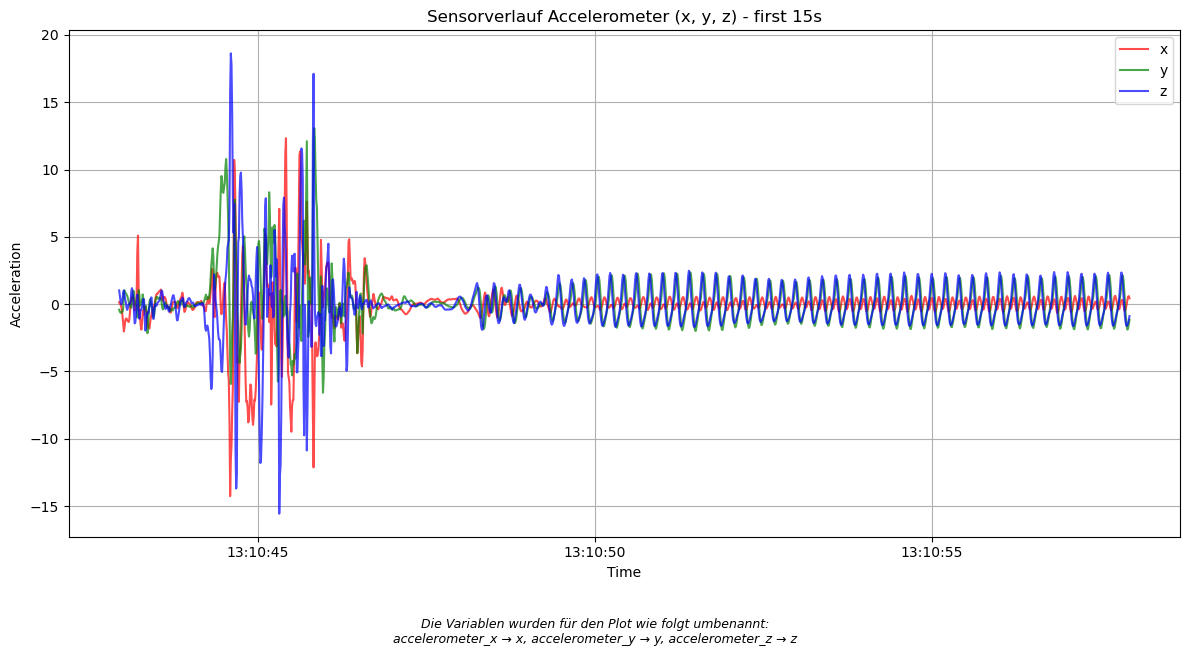

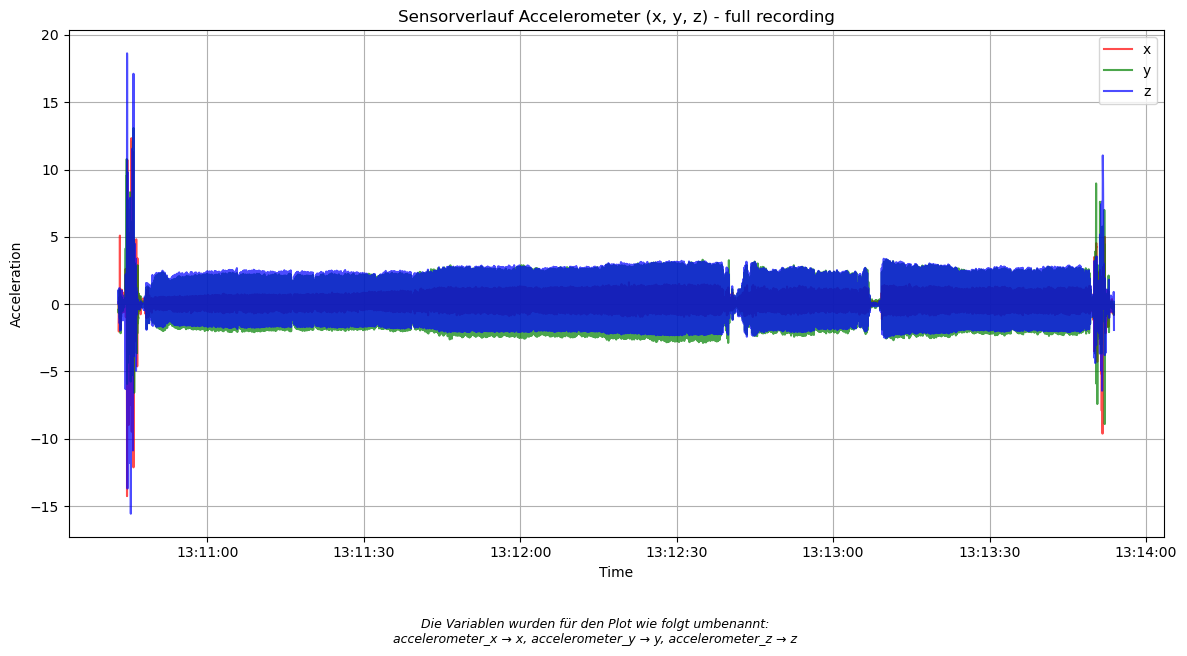

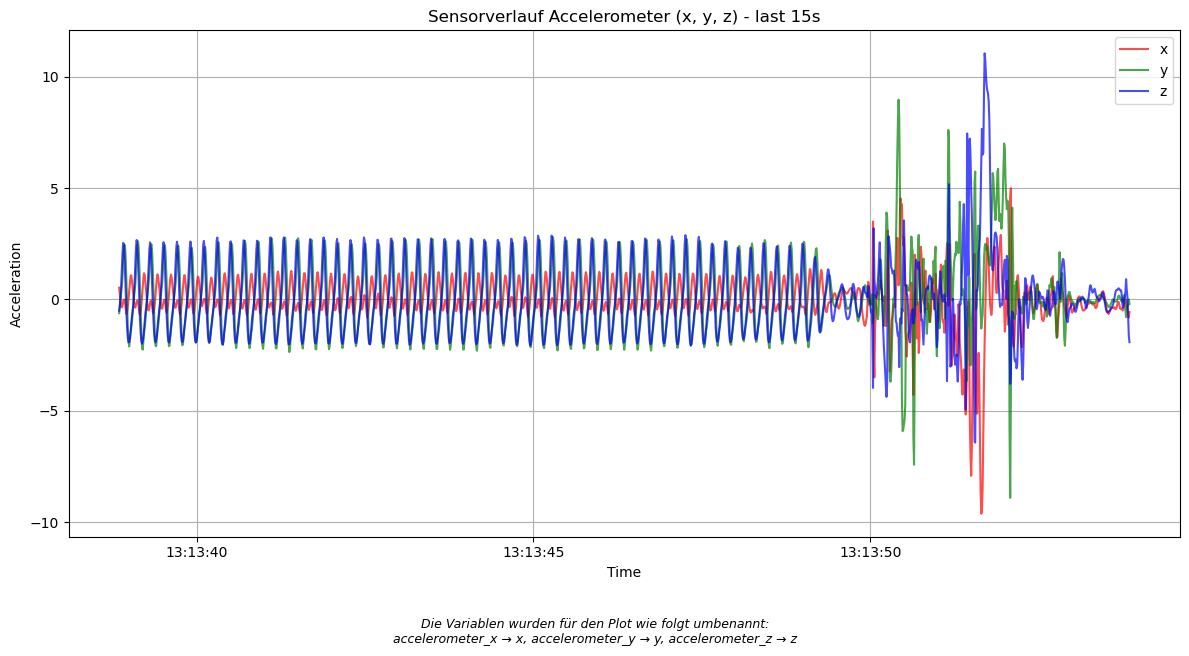

In [7]:
# Umbenennung der Accelerometer-Spalten
df_raw_full = df_raw_full.rename(columns={
    'accelerometer_x': 'x',
    'accelerometer_y': 'y',
    'accelerometer_z': 'z'
})

# Zeitstempel korrekt umwandeln
df_raw_full['time'] = pd.to_datetime(df_raw_full['time'], unit='ns')

# Extrahiere nur die relevanten x/y/z-Daten
df_acc_raw = df_raw_full[['time', 'x', 'y', 'z']].copy()
df_acc_raw = df_acc_raw.set_index('time').sort_index()

plot_data(df_acc_raw, title="Sensorverlauf Accelerometer (x, y, z) - first 15s", duration=15)
plot_data(df_acc_raw, title="Sensorverlauf Accelerometer (x, y, z) - full recording")
plot_data(df_acc_raw, title="Sensorverlauf Accelerometer (x, y, z) - last 15s", duration=-15)

---

## 2. Zeitbasiertes Trimmen & Resampling

Die Funktion preprocess_dataframe ist ein vielseitiges Werkzeug zur Vorbereitung von Zeitreihendaten für die Analyse. Sie nimmt ein pandas DataFrame mit Rohdaten, wie z. B. Sensordaten, und führt mehrere Vorverarbeitungsschritte durch, darunter Zeitkonvertierung, Zuschneiden, Resampling und Interpolation. Durch die Umwandlung von Zeitstempeln, das Filtern numerischer Spalten und das Resampling der Daten auf eine gewünschte Frequenz sorgt die Funktion dafür, dass die Daten sauber, konsistent und bereit für weitere Verarbeitung oder Modellierung sind. 

In [8]:
def preprocess_dataframe(
    df: pd.DataFrame,
    time_col: str = 'time',
    drop_initial: float = 8.0,
    drop_final: float = 8.0,
    sampling_rate: float = 50.0,
    apply_trim: bool = True
) -> pd.DataFrame:
    """
    1. Konvertiere die Zeitspalte (Nanosekunden) in datetime-Objekte.
    2. Setze den Zeitstempel als Index und sortiere nach Zeit.
    3. Optional: Schneide die ersten 'drop_initial' und letzten 'drop_final' Sekunden ab.
    4. Resample auf die gewünschte 'sampling_rate' (Hz):
       - Mittelwert in jedem Intervall
       - lineare Interpolation fehlender Werte

    Rückgabe: DataFrame mit nur numerischen Spalten, indexiert nach Zeit in der neuen Sampling-Rate.
    """
    df = df.copy()
    if time_col not in df.columns:
        raise ValueError(f"Zeitspalte '{time_col}' nicht gefunden. Verfügbare Spalten: {df.columns.tolist()}")

    # 1. Zeitkonvertierung: Nanosekunden → pandas datetime
    df[time_col] = pd.to_datetime(df[time_col], unit='ns')

    # 2. Setze Zeitspalte als Index und sortiere
    df = df.set_index(time_col).sort_index()
    if df.empty:
        raise ValueError("DataFrame ist nach Setzen des Zeit-Index leer.")

    # 3. Optional: Trimme Anfang und Ende
    if apply_trim:
        start = df.index[0] + pd.Timedelta(seconds=drop_initial)
        end = df.index[-1] - pd.Timedelta(seconds=drop_final)
        df = df[(df.index >= start) & (df.index <= end)]
        if df.empty:
            raise ValueError("DataFrame ist nach Entfernen der Randzeiten leer.")

    # 4. Nur numerische Spalten auswählen (Sensorwerte)
    num_cols = df.select_dtypes(include='number').columns
    if len(num_cols) == 0:
        raise ValueError("Keine numerischen Spalten für das Resampling gefunden.")
    df_num = df[num_cols]

    # 5. Resampling
    rule = f"{int(1e6 / sampling_rate)}us"
    df_resampled = df_num.resample(rule).mean().interpolate()
    if df_resampled.empty:
        raise ValueError("DataFrame ist nach Resampling leer.")

    return df_resampled

Im nächsten Schritt extrahieren wir die Spalten time, x, y, z und wenden preprocess_dataframe() an, um:

-> die Daten auf 50 Hz zu resamplen,

-> jeweils 8 Sekunden am Anfang und Ende zu trimmen.

Anschliessend plotten wir die verarbeiteten Daten (erste 15 s, gesamte Dauer, letzte 15 s) und vergleichen sie mit den Rohdaten. Der Vergleich zeigt klar die geglättete und gleichmäßig abgetastete Struktur der resampleten Daten.

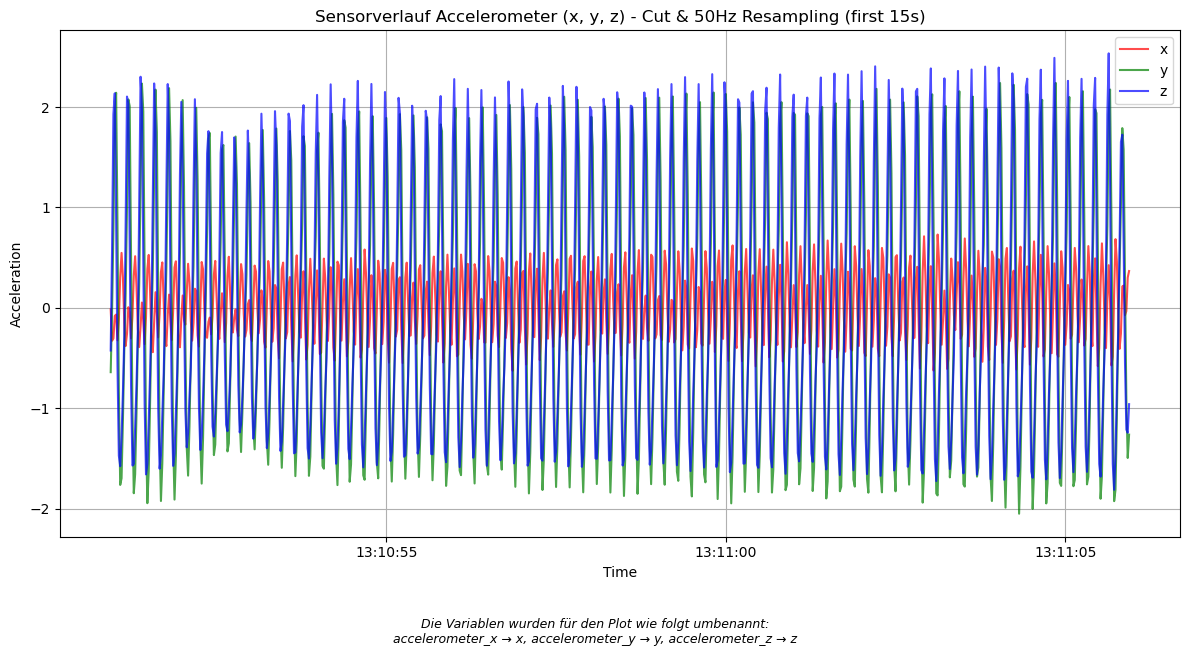

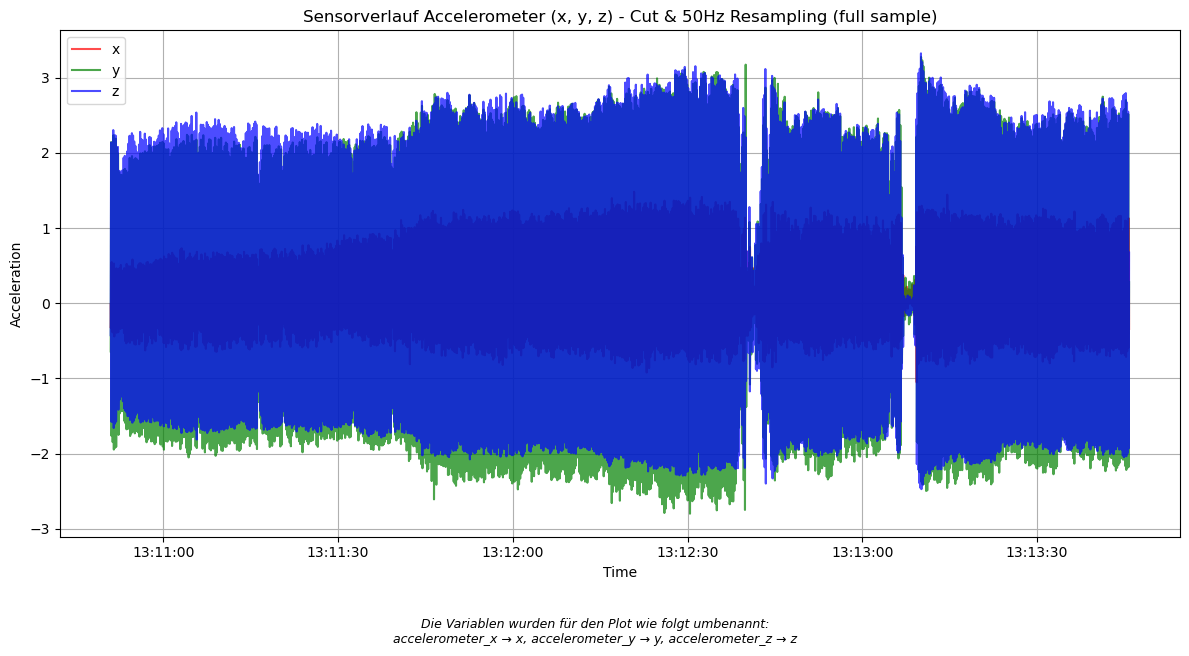

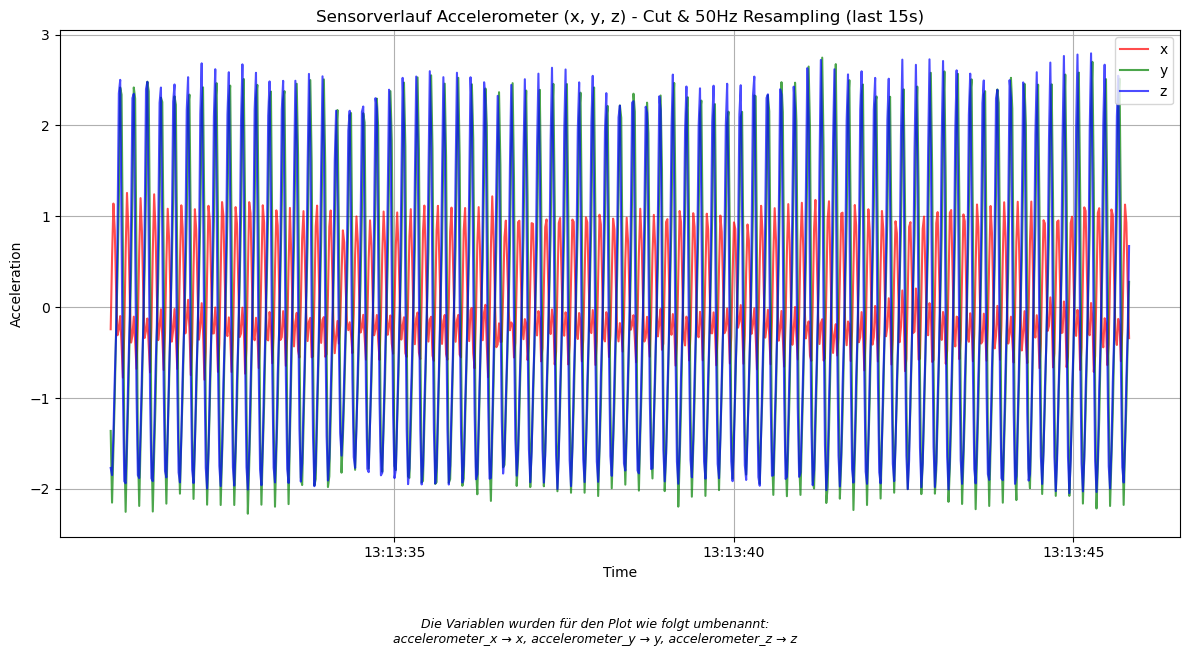

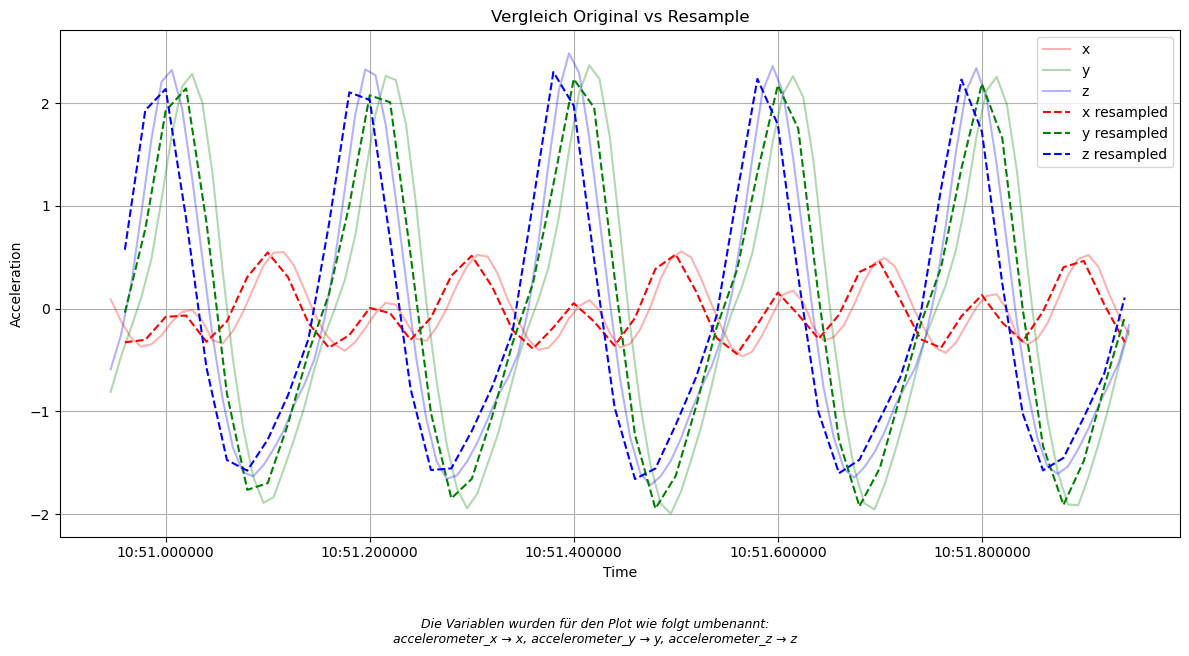

In [9]:
df_acc_input = df_raw_full[['time', 'x', 'y', 'z']].copy()
df_acc_processed = preprocess_dataframe(df_acc_input)

# Visualisierung der verarbeiteten Daten
plot_data(df_acc_processed, title="Sensorverlauf Accelerometer (x, y, z) - Cut & 50Hz Resampling (first 15s)", duration=15)
plot_data(df_acc_processed, title="Sensorverlauf Accelerometer (x, y, z) - Cut & 50Hz Resampling (full sample)")
plot_data(df_acc_processed, title="Sensorverlauf Accelerometer (x, y, z) - Cut & 50Hz Resampling (last 15s)", duration=-15)

# Trim der Rohdaten auf denselben Zeitraum für Vergleich
start, end = df_acc_processed.index.min(), df_acc_processed.index.max()
df_acc_raw_trimmed = df_acc_raw[(df_acc_raw.index >= start) & (df_acc_raw.index <= end)]

# Vergleich Original vs. Resample
plot_data(df=df_acc_raw_trimmed, title="Vergleich Original vs Resample", duration=1, compare_to=df_acc_processed, alpha=0.3)

---
## 3. Segmentierung in überlappende Zeitfenster

Die Funktion segment_dataframe dient dazu, kontinuierliche Zeitreihendaten in gleich lange, überlappende Zeitfenster zu unterteilen. Dies ist ein zentraler Schritt bei der Vorbereitung von Sensordaten für Feature-Extraktion oder Deep-Learning-Modelle. Die Fensterlänge (z. B. 5 Sekunden) und die Überlappung (z. B. 1 Sekunde) lassen sich flexibel anpassen. Jedes zurückgegebene Segment ist ein DataFrame mit dem Zeitindex des ursprünglichen Signals und enthält genau den entsprechenden Abschnitt des Signals. So entsteht eine Serie überlappender, strukturierter Datenblöcke für die weitere Analyse.


In [10]:
def segment_dataframe(
    df: pd.DataFrame,
    segment_length: float = 5.0,
    overlap: float = 1.0
) -> list[pd.DataFrame]:
    """
    Teilt 'df' in überlappende Fenster auf:
    - segment_length: Länge eines Fensters in Sekunden (z.B. 5.0)
    - overlap: Überlappung zwischen Fenstern in Sekunden (z.B. 1.0)

    Rückgabe: Liste von DataFrames, jedes entspricht einem Segment (Index = Zeit).
    """
    seg_len = pd.Timedelta(seconds=segment_length)
    ov = pd.Timedelta(seconds=overlap)
    segments: list[pd.DataFrame] = []

    t0 = df.index.min()
    t_max = df.index.max()
    while t0 + seg_len <= t_max:
        t1 = t0 + seg_len
        seg = df[t0:t1]   # Schneide Index von t0 bis t1
        if not seg.empty:
            segments.append(seg)
        t0 = t1 - ov  # Nächster Startpunkt = Ende des alten Segments minus Overlap

    if not segments:
        raise ValueError("Keine Segmente erstellt. Überprüfe 'segment_length' und 'overlap'.")
    return segments

Nach dem Trimming und Resampling unterteilen wir die Zeitreihe in überlappende Segmente fester Länge – hier 5 Sekunden mit 1 Sekunde Überlappung. Diese Segmentierung bildet die Grundlage für Feature-Extraktion oder sequenzbasierte Modellierung. Anschließend werden exemplarisch die ersten drei Segmente visualisiert, um den Erfolg der Segmentierung zu überprüfen.

-------------------------------------
Anzahl der Segmente: 43
-------------------------------------


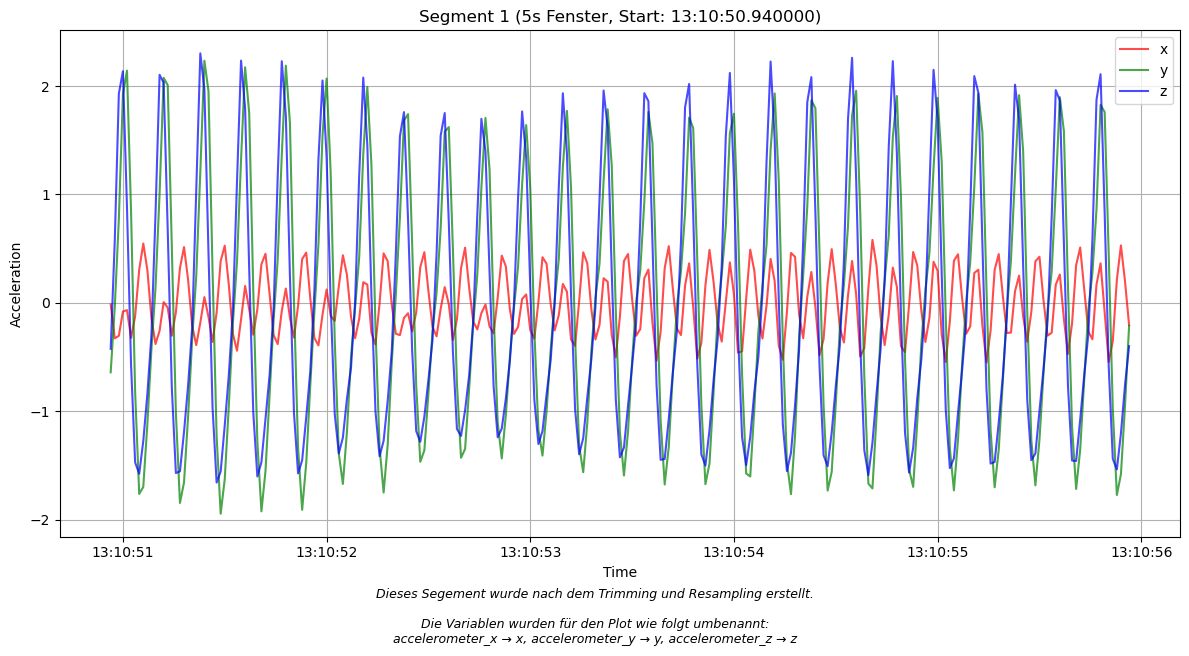

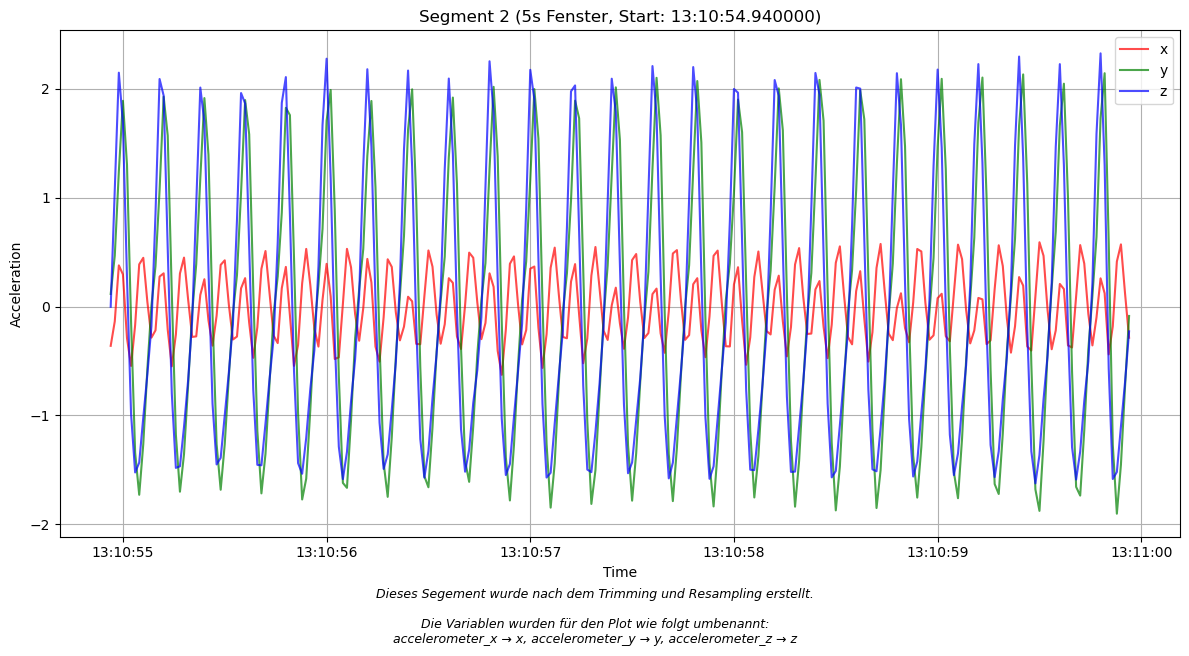

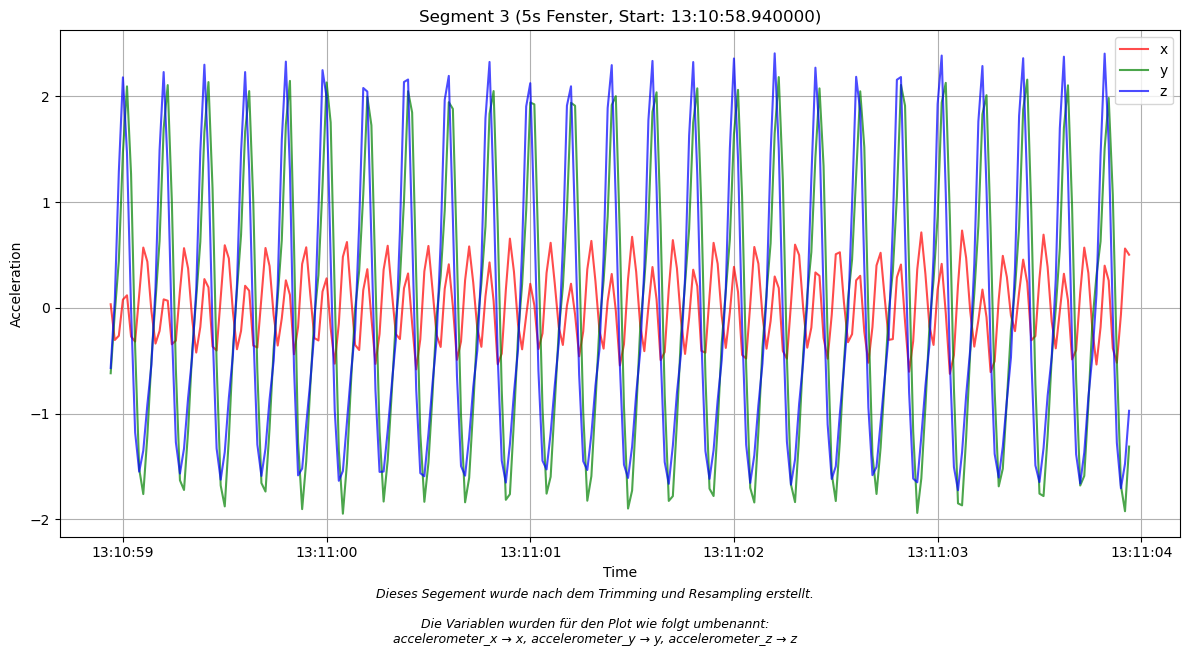

In [11]:
# Segmentierung der resampleten Daten durchführen
segments = segment_dataframe(df_acc_processed, segment_length=5.0, overlap=1.0)

# Anzahl der erzeugten Segmente ausgeben
print("-------------------------------------")
print(f"Anzahl der Segmente: {len(segments)}")
print("-------------------------------------")

# Die ersten drei Segmente plotten
for i in range(min(3, len(segments))):
    seg_df = segments[i]
    title = f"Segment {i+1} (5s Fenster, Start: {seg_df.index.min().time()})"
    plot_data(seg_df, title=title, own_comment="Dieses Segement wurde nach dem Trimming und Resampling erstellt.")

---
## 4. Glättung jedes Segments

Die Funktion moving_average glättet die resampleten Zeitreihendaten segmentweise mithilfe eines gleitenden Durchschnitts. Dabei wird über ein definiertes Zeitfenster – z. B. 0.1 Sekunden bei einer Samplingrate von 50 Hz – der Mittelwert für jede Spalte berechnet. Diese Methode reduziert kurzfristige Schwankungen im Sensorsignal, ohne den grundlegenden Verlauf zu verändern.

Da die Glättung innerhalb der einzelnen Segmente erfolgt, wird verhindert, dass Informationen über Segmentgrenzen hinweg ungewollt einfließen (Data Leakage). Das macht sie ideal für klassische Machine-Learning-Modelle, bei denen eine stabile Signalbasis für die Merkmalsextraktion wichtig ist.

In [12]:
def moving_average(
    df: pd.DataFrame,
    window_sec: float = 0.1,
    sampling_rate: float = 50.0
) -> pd.DataFrame:
    """
    Wendet einen gleitenden Durchschnitt (Moving Average) auf alle Spalten von 'df' an:
    - window_sec: Fenstergröße in Sekunden (z.B. 0.1s)
    - sampling_rate: Sampling-Rate in Hz (z.B. 50)

    Rückgabe: Geglättetes DataFrame (gleiche Dimension wie Input).
    """
    w = int(window_sec * sampling_rate)
    if w < 1:
        w = 1
    df_smooth = df.rolling(window=w, center=True, min_periods=1).mean()
    return df_smooth

Im nächsten Schritt wenden wir diese Methode auf die ersten drei Segmente an und visualisieren das Ergebnis im Vergleich zur ungefilterten Version.

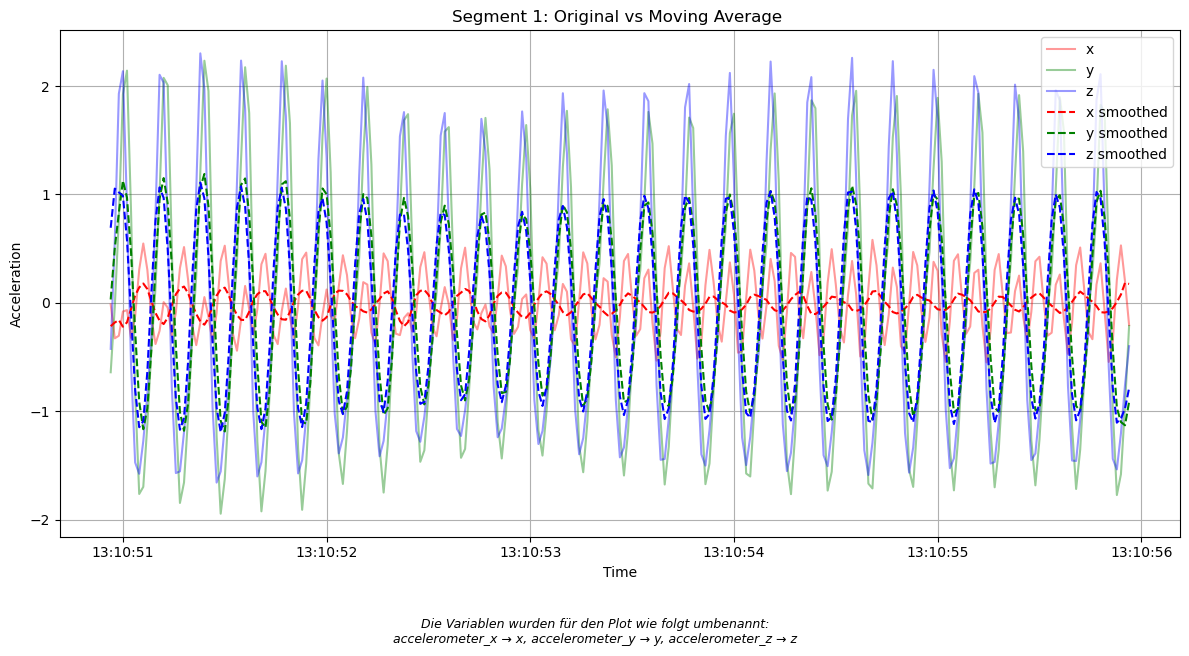

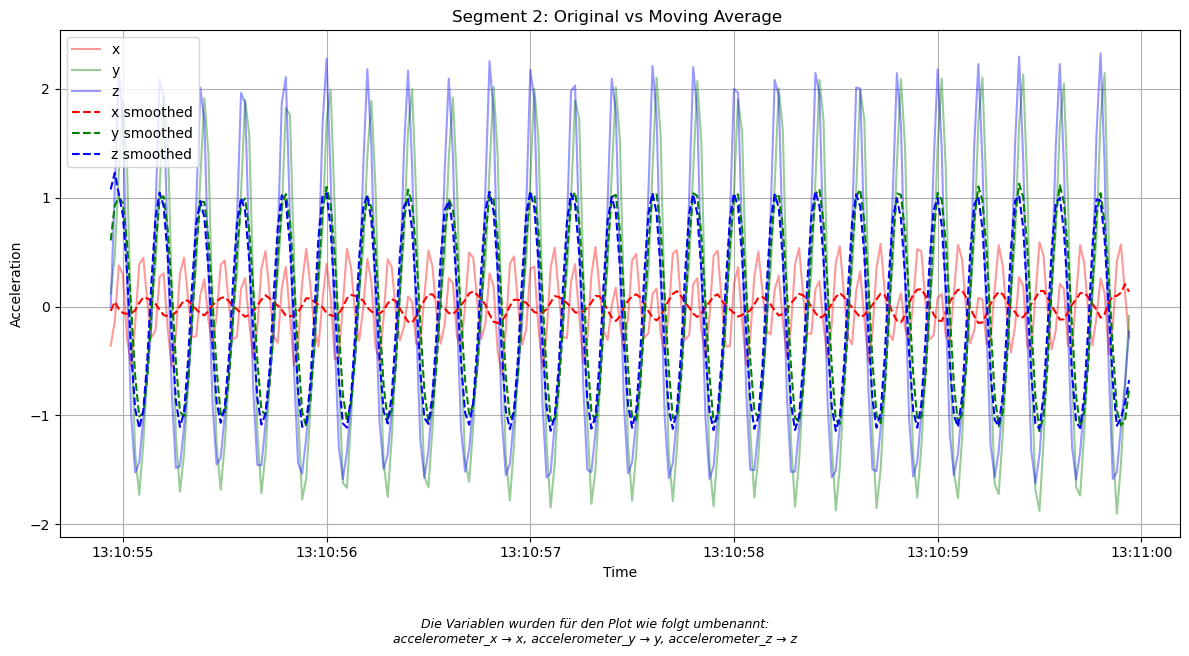

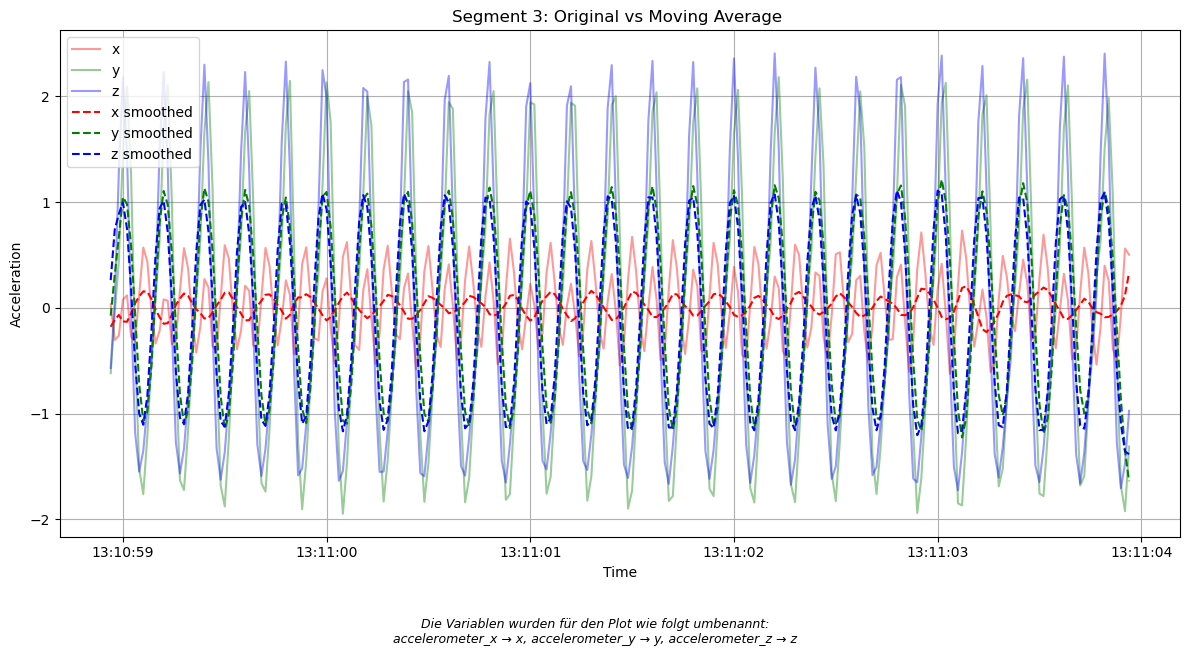

In [13]:
for i in range(min(3, len(segments))):
    seg = segments[i]

    seg_smooth = moving_average(seg, window_sec=0.1, sampling_rate=50.0)

    plot_data(
        df=seg,
        compare_to=seg_smooth,
        title=f"Segment {i+1}: Original vs Moving Average ",
        alpha=0.4,
        axes_name="",
        axes_name_compare=" smoothed"
    )

---
## 5. Feature-Extraktion (für NDL)

Die Funktion extract_features berechnet für jedes Segment eine Reihe statistischer Kennwerte: Mittelwert, Standardabweichung, Minimum und Maximum – jeweils für jede Sensorkomponente (x, y, z). Diese Merkmale fassen die zeitliche Dynamik innerhalb eines Fensters kompakt zusammen und bilden eine typische Grundlage für Non Deepl Learning Modelle.

Jedes Segment wird zu einer Zeile im resultierenden Feature-DataFrame, wobei die Spalten die extrahierten Merkmale repräsentieren und der Index die Segment-ID darstellt.

In [14]:
def extract_features(segments: list[pd.DataFrame]) -> pd.DataFrame:
    """
    Berechnet für jedes Segment die statistischen Kennwerte:
    - Mittelwert, Standardabweichung, Minimum, Maximum jeder Spalte.

    Rückgabe: DataFrame mit einer Zeile pro Segment und Index 'segment_id'.
    """
    rows = []
    for i, seg in enumerate(segments):
        feats: dict[str, float] = {}
        for col in seg.columns:
            feats[f"{col}_mean"] = seg[col].mean()
            feats[f"{col}_std"]  = seg[col].std()
            feats[f"{col}_min"]  = seg[col].min()
            feats[f"{col}_max"]  = seg[col].max()
        feats['segment_id'] = i
        rows.append(feats)

    if not rows:
        raise ValueError("Keine Segmente vorhanden. Feature-Extraktion nicht möglich.")
    return pd.DataFrame(rows).set_index('segment_id')

In [15]:
features_df = extract_features(segments)
features_df.head()

,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max
segment_id,,,,,,,,,,,,
0,-0.011536,0.295562,-0.549107,0.581137,-0.007590,1.192337,-1.945089,2.233798,-0.044135,1.206782,-1.658169,2.301771
1,0.003968,0.318830,-0.627109,0.591388,-0.002665,1.230941,-1.903576,2.144935,-0.045485,1.254486,-1.624927,2.327450
2,0.016940,0.350543,-0.624129,0.730336,0.000284,1.290359,-1.946730,2.181074,-0.048582,1.308894,-1.724751,2.405363
3,0.028021,0.359215,-0.624129,0.730336,0.013454,1.303743,-2.049806,2.240041,-0.045880,1.333630,-1.811824,2.534748
4,0.039850,0.381610,-0.645599,0.676871,0.021995,1.291991,-2.027767,2.199368,-0.039748,1.328660,-1.724694,2.446934


---
## 6. Label-Zuordnung

Die Funktion get_label_per_segment weist jedem Segment ein Label zu, basierend auf den im ursprünglichen Rohdaten-DataFrame enthaltenen Aktivitätsannotationen. Für jedes Segment wird das Zeitintervall bestimmt und der häufigste Wert (Modalwert) der Aktivität innerhalb dieses Zeitfensters ermittelt. Diese Vorgehensweise eignet sich besonders bei leicht verrauschten oder uneinheitlichen Annotationen.

In [16]:
def get_label_per_segment(
    raw_df: pd.DataFrame,
    segments: list[pd.DataFrame],
    time_col: str = 'time',
    label_col: str = 'activity'
) -> list:
    """
    Ordnet jedem Segment das Label zu, das im Original-DataFrame (raw_df) am häufigsten vorkommt:
    - raw_df enthält die Rohdaten mit Zeitstempel und Label-Spalte.
    - segments sind bereits gefilterte/glättete DataFrames mit Index=Zeit.

    Rückgabe: Liste von Labels (Modalwert) pro Segment. Fehlt ein Label, wird None gesetzt.
    """
    if label_col not in raw_df.columns:
        raise ValueError(f"Spalte '{label_col}' nicht in raw_df vorhanden.")

    # Indexiere raw_df nach Zeit
    label_series = raw_df.set_index(pd.to_datetime(raw_df[time_col], unit='ns'))[label_col]
    labels = []

    for seg in segments:
        start_ts = seg.index.min()
        end_ts   = seg.index.max()
        seg_labels = label_series[start_ts:end_ts]
        if not seg_labels.empty:
            labels.append(seg_labels.mode().iloc[0])
        else:
            labels.append(None)
    return labels

Diese Methode ist notwendig für klassisches Supervised Learning – denn jedes Segment benötigt ein eindeutiges Ziel-Label (z. B. "sitting", “walking”, “jogging”). Sie funktioniert auch dann robust, wenn mehrere Labels innerhalb eines Fensters vorkommen, indem einfach das am häufigsten auftretende verwendet wird.

Fehlt ein Label im betrachteten Zeitfenster, wird None zugewiesen.

Anzahl Labels: 43
Erste 10 Labels: ['sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting', 'sitting']


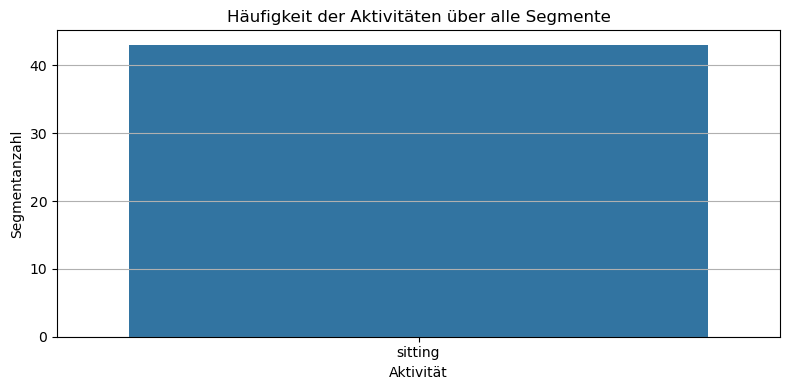

In [17]:
labels_per_segment = get_label_per_segment(
    raw_df=df_raw_full,
    segments=segments,
)

print(f"Anzahl Labels: {len(labels_per_segment)}")
print("Erste 10 Labels:", labels_per_segment[:10])

label_series = pd.Series(labels_per_segment, name="Aktivität")
plt.figure(figsize=(8, 4))
sns.countplot(x=label_series)
plt.title("Häufigkeit der Aktivitäten über alle Segmente")
plt.xlabel("Aktivität")
plt.ylabel("Segmentanzahl")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

---
## 7. Sequenzbildung (für DL)

Die Funktion get_files_list dient dazu, Eingabedateien für die weitere Verarbeitung zu sammeln. Sie akzeptiert entweder:

-> einen einzelnen Dateipfad (z. B. eine .parquet-Datei), oder

-> ein Verzeichnis, aus dem alle Dateien passend zum angegebenen Muster (z. B. *.parquet) extrahiert werden.

Sie prüft die Eingabe auf Gültigkeit und gibt eine Liste von Path-Objekten zurück, die anschließend iterativ verarbeitet werden können.

In [18]:
def get_files_list(raw_dir: Path, pattern: str = "*.parquet") -> list[Path]:
    """
    Gibt eine Liste von Parquet-Dateien zurück:
    - Wenn raw_dir eine Datei ist, wird diese Datei in einer Liste zurückgegeben.
    - Wenn raw_dir ein Verzeichnis ist, werden alle Dateien, die zu 'pattern' passen (z.B. '*.parquet'), zurückgegeben.

    Rückgabe: Liste von Path-Objekten
    """
    if raw_dir.is_file():
        return [raw_dir]
    elif raw_dir.is_dir():
        files = list(raw_dir.glob(pattern))
        if not files:
            raise ValueError(f"Keine Dateien mit Muster '{pattern}' in '{raw_dir}' gefunden.")
        return files
    else:
        raise ValueError(f"'{raw_dir}' ist weder eine Datei noch ein Verzeichnis.")